Notebook for the assessment of the PCF project.

In [1]:
cd ..

C:\Users\giaco\sbp-adoption-abm-operational\abm


In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import geopandas as gpd
import os
import csv
import scipy.stats

from abm.model import SBPAdoption

from abm.custom_transformers import (
    TransformCensusFeatures,
    TransformClimateFeatures,
    TransformSoilFeatures,
    )

In [3]:
%matplotlib inline

mpl.rc('axes', labelsize=14)

tick_size = 11
mpl.rc('xtick', labelsize=tick_size)
mpl.rc('ytick', labelsize=tick_size)

plt.rcParams["font.family"] = "Calibri"

In [4]:
# Size of figures
fig_x = 8
fig_y = 5

In [5]:
# Line necessary to import agents in model, since the cwd of the notebook server is always the base path where you started the 
# server 
import sys
sys.path.append(".\abm")

In [6]:
# How to display floats
pd.options.display.float_format = '{:.6f}'.format
#np.set_printoptions(precision=6)
np.set_printoptions(formatter={'float': lambda x: "{0:0.6f}".format(x)})

In [7]:
# Where to save the figures
PROJECT_ROOT_DIR = "pcf_project_assessment"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "output/images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=False, fig_extension="jpeg", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Real data loading

In [8]:
path_to_adoption_port_real = "./pcf_project_assessment/data/SBP yearly adoption - Portugal.csv"
yearly_adoption_portugal_real = pd.read_csv(path_to_adoption_port_real, index_col=0)
yearly_adoption_portugal_real.drop(1995, inplace=True)

# Model runs and data collection

In [9]:
n_runs = 50

In [10]:
def collect_data_run(model, n_run, df):  
    # Aggregate adoption
    aggr_adoption_out = model.datacollector.get_model_vars_dataframe()
    aggr_adoption_out.set_index('Year', inplace=True)
    col_name = 'Run ' + str(n_run+1)
    df[col_name] = aggr_adoption_out['Yearly area of SBP sown [ha/y]']

## Model with payments from 2013 to 2020

In [11]:
start_year = 2013
stop_year = 2021

In [12]:
years = np.arange(start_year, stop_year)

In [13]:
# Set dataframes to collect yearly adoption in Portugal with payments
yearly_adoption_portugal_pred = pd.DataFrame(index=years)
yearly_adoption_portugal_pred.index.rename('Year', inplace=True)

In [14]:
%%time

for i in range(n_runs):
    model = SBPAdoption(initial_year=start_year, seed=i)
    for y in range(start_year, stop_year):
        model.step()
        print("Run n° " + str(i+1) + ": year " + str(y) + " step completed.")
    collect_data_run(model, i, yearly_adoption_portugal_pred)

Run n° 1: year 2013 step completed.
Run n° 1: year 2014 step completed.
Run n° 1: year 2015 step completed.
Run n° 1: year 2016 step completed.
Run n° 1: year 2017 step completed.
Run n° 1: year 2018 step completed.
Run n° 1: year 2019 step completed.
Run n° 1: year 2020 step completed.
Run n° 2: year 2013 step completed.
Run n° 2: year 2014 step completed.
Run n° 2: year 2015 step completed.
Run n° 2: year 2016 step completed.
Run n° 2: year 2017 step completed.
Run n° 2: year 2018 step completed.
Run n° 2: year 2019 step completed.
Run n° 2: year 2020 step completed.
Run n° 3: year 2013 step completed.
Run n° 3: year 2014 step completed.
Run n° 3: year 2015 step completed.
Run n° 3: year 2016 step completed.
Run n° 3: year 2017 step completed.
Run n° 3: year 2018 step completed.
Run n° 3: year 2019 step completed.
Run n° 3: year 2020 step completed.
Run n° 4: year 2013 step completed.
Run n° 4: year 2014 step completed.
Run n° 4: year 2015 step completed.
Run n° 4: year 2016 step com

Run n° 29: year 2013 step completed.
Run n° 29: year 2014 step completed.
Run n° 29: year 2015 step completed.
Run n° 29: year 2016 step completed.
Run n° 29: year 2017 step completed.
Run n° 29: year 2018 step completed.
Run n° 29: year 2019 step completed.
Run n° 29: year 2020 step completed.
Run n° 30: year 2013 step completed.
Run n° 30: year 2014 step completed.
Run n° 30: year 2015 step completed.
Run n° 30: year 2016 step completed.
Run n° 30: year 2017 step completed.
Run n° 30: year 2018 step completed.
Run n° 30: year 2019 step completed.
Run n° 30: year 2020 step completed.
Run n° 31: year 2013 step completed.
Run n° 31: year 2014 step completed.
Run n° 31: year 2015 step completed.
Run n° 31: year 2016 step completed.
Run n° 31: year 2017 step completed.
Run n° 31: year 2018 step completed.
Run n° 31: year 2019 step completed.
Run n° 31: year 2020 step completed.
Run n° 32: year 2013 step completed.
Run n° 32: year 2014 step completed.
Run n° 32: year 2015 step completed.
R

## Model without payments from 2009 to 2020

In [15]:
start_year_nop = 2009
stop_year_nop = 2021

In [16]:
years_nop = np.arange(start_year_nop, stop_year_nop)

In [17]:
# Set dataframes to collect yearly adoption in Portugal without payments
yearly_adoption_portugal_pred_nop = pd.DataFrame(index=years_nop)
yearly_adoption_portugal_pred_nop.index.rename('Year', inplace=True)

In [18]:
%%time

sbp_payments_path = "./data/sbp_payments_all0.xlsx"

for i in range(n_runs):
    model_nop = SBPAdoption(initial_year=start_year_nop, seed=i, sbp_payments_path=sbp_payments_path)
    for y in range(start_year_nop, stop_year_nop):
        model_nop.step()
        print("Run n° " + str(i+1) + ": year " + str(y) + " step completed.")
    collect_data_run(model_nop, i, yearly_adoption_portugal_pred_nop)

Run n° 1: year 2009 step completed.
Run n° 1: year 2010 step completed.
Run n° 1: year 2011 step completed.
Run n° 1: year 2012 step completed.
Run n° 1: year 2013 step completed.
Run n° 1: year 2014 step completed.
Run n° 1: year 2015 step completed.
Run n° 1: year 2016 step completed.
Run n° 1: year 2017 step completed.
Run n° 1: year 2018 step completed.
Run n° 1: year 2019 step completed.
Run n° 1: year 2020 step completed.
Run n° 2: year 2009 step completed.
Run n° 2: year 2010 step completed.
Run n° 2: year 2011 step completed.
Run n° 2: year 2012 step completed.
Run n° 2: year 2013 step completed.
Run n° 2: year 2014 step completed.
Run n° 2: year 2015 step completed.
Run n° 2: year 2016 step completed.
Run n° 2: year 2017 step completed.
Run n° 2: year 2018 step completed.
Run n° 2: year 2019 step completed.
Run n° 2: year 2020 step completed.
Run n° 3: year 2009 step completed.
Run n° 3: year 2010 step completed.
Run n° 3: year 2011 step completed.
Run n° 3: year 2012 step com

Run n° 19: year 2018 step completed.
Run n° 19: year 2019 step completed.
Run n° 19: year 2020 step completed.
Run n° 20: year 2009 step completed.
Run n° 20: year 2010 step completed.
Run n° 20: year 2011 step completed.
Run n° 20: year 2012 step completed.
Run n° 20: year 2013 step completed.
Run n° 20: year 2014 step completed.
Run n° 20: year 2015 step completed.
Run n° 20: year 2016 step completed.
Run n° 20: year 2017 step completed.
Run n° 20: year 2018 step completed.
Run n° 20: year 2019 step completed.
Run n° 20: year 2020 step completed.
Run n° 21: year 2009 step completed.
Run n° 21: year 2010 step completed.
Run n° 21: year 2011 step completed.
Run n° 21: year 2012 step completed.
Run n° 21: year 2013 step completed.
Run n° 21: year 2014 step completed.
Run n° 21: year 2015 step completed.
Run n° 21: year 2016 step completed.
Run n° 21: year 2017 step completed.
Run n° 21: year 2018 step completed.
Run n° 21: year 2019 step completed.
Run n° 21: year 2020 step completed.
R

Run n° 38: year 2012 step completed.
Run n° 38: year 2013 step completed.
Run n° 38: year 2014 step completed.
Run n° 38: year 2015 step completed.
Run n° 38: year 2016 step completed.
Run n° 38: year 2017 step completed.
Run n° 38: year 2018 step completed.
Run n° 38: year 2019 step completed.
Run n° 38: year 2020 step completed.
Run n° 39: year 2009 step completed.
Run n° 39: year 2010 step completed.
Run n° 39: year 2011 step completed.
Run n° 39: year 2012 step completed.
Run n° 39: year 2013 step completed.
Run n° 39: year 2014 step completed.
Run n° 39: year 2015 step completed.
Run n° 39: year 2016 step completed.
Run n° 39: year 2017 step completed.
Run n° 39: year 2018 step completed.
Run n° 39: year 2019 step completed.
Run n° 39: year 2020 step completed.
Run n° 40: year 2009 step completed.
Run n° 40: year 2010 step completed.
Run n° 40: year 2011 step completed.
Run n° 40: year 2012 step completed.
Run n° 40: year 2013 step completed.
Run n° 40: year 2014 step completed.
R

## Save and load model output

In [19]:
#os.mkdir("pcf_project_assessment/output")
yearly_adoption_portugal_pred.to_csv("pcf_project_assessment/output/estimation_with_paym_2013_2020")
yearly_adoption_portugal_pred_nop.to_csv("pcf_project_assessment/output/estimation_no_paym_2009_2020")

In [20]:
yearly_adoption_portugal_pred = pd.read_csv("pcf_project_assessment/output/estimation_with_paym_2013_2020", index_col='Year')
yearly_adoption_portugal_pred_nop = pd.read_csv("pcf_project_assessment/output/estimation_no_paym_2009_2020", index_col='Year')

## Logistic extrapolation

### Old extrapolation

### New version excluding adoption in Madeira and Azores

In [75]:
from scipy.optimize import curve_fit

In [76]:
def logistic_function(y, r, K, P0):
    """
    r in 1/yr, K and P0 in ha
    """
    return(K * P0 / ((K - P0) * np.exp(-r*(y - 1996)) + P0))

In [77]:
years_for_fit = np.arange(1996, 2009)
cumul_adoption_portugal_real = yearly_adoption_portugal_real.cumsum()
adoption = cumul_adoption_portugal_real.loc[cumul_adoption_portugal_real.index<2009]['Yearly adoption'].values
logistic_params, covariance = curve_fit(logistic_function, years_for_fit, adoption)

In [78]:
logistic_params

array([0.437840, 96234.176989, 3007.763809])

In [79]:
r = logistic_params[0]
K = logistic_params[1]
P0 = logistic_params[2]
print(logistic_params)

[0.437840 96234.176989 3007.763809]


In [80]:
# Cumulative extrapolation
years_to_fit_over = np.arange(1996, 2021)
log_extr = pd.Series(0, years)
for y in years_to_fit_over:
    log_extr.loc[y] = logistic_function(y,  r, K, P0)

In [81]:
# Yearly extrapolation
log_extr_d = pd.Series(0, years_to_fit_over)
for y in years_to_fit_over:
    log_extr_d.loc[y] = r * log_extr.loc[y] * (1 - log_extr.loc[y] / K)

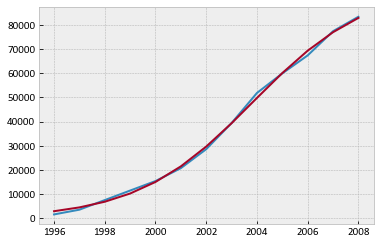

In [82]:
plt.plot(years_for_fit, adoption)
plt.plot(years_for_fit, log_extr.loc[1996:2008])

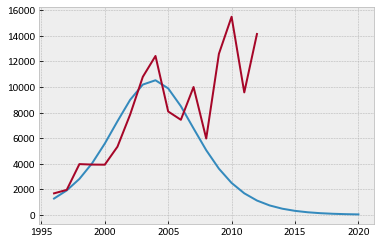

In [83]:
plt.plot(years_to_fit_over, log_extr_d)
plt.plot([y for y  in range(1996, 2013)], yearly_adoption_portugal_real)

# Calculation of additional sequestered carbon

In [84]:
yearly_adoption_portugal_pred_av = yearly_adoption_portugal_pred.mean(axis=1)
yearly_adoption_portugal_pred_nop_av = yearly_adoption_portugal_pred_nop.mean(axis=1)

In [85]:
# Calculate total carbon sequestration factor for 10 years
carb_seq_factors = [14.7, 11.54, 9.15, 7.30, 5.86, 4.72, 3.82, 3.10, 2.53, 2.06]
carb_seq_fact_10y = sum(carb_seq_factors)
print(carb_seq_fact_10y)

64.78


## 2009 - 2012 (Observed adoption vs. Counterfactual estimation)

In [86]:
id_obs = yearly_adoption_portugal_real.index
id_pred_nop = yearly_adoption_portugal_pred_nop_av.index

In [87]:
area_obs_09_12 = yearly_adoption_portugal_real.loc[id_obs >= 2009].sum()['Yearly adoption']
area_pred_nop_09_12 = yearly_adoption_portugal_pred_nop_av.loc[id_pred_nop < 2013].sum()
diff_area_09_12 = area_obs_09_12 - area_pred_nop_09_12

carb_seq_09_12_10y = diff_area_09_12 * carb_seq_fact_10y

In [88]:
print("Additional SBP area installed during the PCF project (2009-2012): ", str(diff_area_09_12), "ha")
print("Additional carbon sequestered during the PCF project (2009-2012): ", str(carb_seq_09_12_10y/1e6), "Mt CO2")

Additional SBP area installed during the PCF project (2009-2012):  34720.57841788065 ha
Additional carbon sequestered during the PCF project (2009-2012):  2.249199069910308 Mt CO2


## 2013 - 2020 (Estimated adoption vs. counterfactual estimation)

In [89]:
id_pred = yearly_adoption_portugal_pred.index

In [90]:
area_pred_13_20 = yearly_adoption_portugal_pred_av.sum()
area_pred_nop_13_20 = yearly_adoption_portugal_pred_nop_av[id_pred_nop >= 2013].sum()
diff_area_13_20 = area_pred_13_20 - area_pred_nop_13_20

carb_seq_09_12_10y = diff_area_09_12 * carb_seq_fact_10y

In [91]:
carb_seq_13_20_10y = diff_area_13_20 * carb_seq_fact_10y
print("Additional SBP area installed during the PCF project (2013-2020): ", str(diff_area_13_20), "ha")
print("Additional carbon sequestered after the PCF project (2013-2020): ", str(carb_seq_13_20_10y/1e6), "Mt CO2")

Additional SBP area installed during the PCF project (2013-2020):  -10930.27035809355 ha
Additional carbon sequestered after the PCF project (2013-2020):  -0.7080629137973002 Mt CO2


## 2009 - 2020 (Total)

In [92]:
diff_area_tot = diff_area_09_12 + diff_area_13_20
carb_seq_tot = diff_area_tot * carb_seq_fact_10y
print("Additional SBP area installed thanks to the PCF project (2009-2020): ", str(diff_area_tot), "ha")
print("Additional carbon sequestered thanks to the PCF project (2009-2020): ", str(carb_seq_tot/1e6), "Mt CO2")

Additional SBP area installed thanks to the PCF project (2009-2020):  23790.3080597871 ha
Additional carbon sequestered thanks to the PCF project (2009-2020):  1.5411361561130086 Mt CO2


# Comparison with previous logistic extrapolation

In [93]:
id_log = log_extr_d.index
area_log_09_12 = log_extr_d.loc[(id_log >= 2009) & (id_log <= 2012)].sum()
diff_area_09_12_extr = area_pred_nop_09_12 - area_log_09_12

In [94]:
print("Difference of additional SBP area installed during the PCF project estimated by the two extrapolations: ",
      str(diff_area_09_12_extr), "ha")

Difference of additional SBP area installed during the PCF project estimated by the two extrapolations:  8147.257928977109 ha


In [95]:
# In percentage over previous estimation of additional area
perc_diff = (diff_area_09_12_extr / (area_obs_09_12 - area_log_09_12) * 100)
print("Difference of additional SBP area installed during the PCF project estimated by the two extrapolations, in %: ",
      str(perc_diff), "%")

Difference of additional SBP area installed during the PCF project estimated by the two extrapolations, in %:  19.005526341602515 %


# Plot of runs and average value over real adoption

In [96]:
def plot_differential_adoption_all(predicted_adoption, predicted_adoption_no_p, real_adoption, log_extr_adoption,
                                   max_y, fig_title):
    # Base figure
    fig_pr, ax_pr = plt.subplots()
    fig_pr.set_size_inches(fig_x, fig_y)
    ts = 16
    plt.xticks(fontsize=ts) 
    plt.yticks(fontsize=ts)
    ls = 20
    ax_pr.set_xlabel("Years", fontsize=ls)
    ax_pr.set_ylabel("Area installed [ha]", fontsize=ls)
    #ax_pr.set_title(fig_title, fontsize=18)
    ax_pr.set_xlim(predicted_adoption.index[0], predicted_adoption.index[-1])
    xticks = [year for year in np.arange(1996, 2021) if year%4 == 0]
    ax_pr.set_xticks(xticks)
    yticks = np.arange(0, 21000, 5000)
    ax_pr.set_yticks(yticks)
    ax_pr.set_ylim(0, max_y)
    ax_pr.grid(True)

    # Plot adoptions
    pred_adoption_av = predicted_adoption.mean(axis=1)
    pred_adoption_no_p_av = predicted_adoption_no_p.mean(axis=1)
    pred_vals = pred_adoption_av.values
    pred_nop_vals = pred_adoption_no_p_av.values
    
    lw = 1
    ms = 14

    ax_pr.plot(real_adoption.index, real_adoption.values, 'r--', linewidth=lw, marker='.', markersize=ms,
               label='Observed')
    ax_pr.plot(pred_adoption_av.index, pred_vals, 'c--', linewidth=lw, marker='.', markersize=ms,
               label='Estimated')
    point1 = [real_adoption]
    ax_pr.plot([2012, 2013], [real_adoption.loc[2012], pred_adoption_av.loc[2013]], 'c--', linewidth=lw)
    ax_pr.plot(pred_adoption_no_p_av.index, pred_nop_vals, 'b--', linewidth=lw, marker='.', markersize=ms,
               label='Estimated without payments')
    ax_pr.plot([2008, 2009], [real_adoption.loc[2008], pred_adoption_no_p_av.loc[2009]], 'b--', linewidth=lw)

    log_extr_from_2009 = log_extr_adoption.loc[log_extr_adoption.index > 2008]
    ax_pr.plot(log_extr_from_2009.index, log_extr_from_2009.values, 'g--', linewidth=lw, marker='.', markersize=ms,
               label='Logistic extrapolation')
    #ax_pr.plot([2008, 2009], [real_adoption.loc[2008], log_extr_from_2009.loc[2009]], 'g--', linewidth=lw)
    ax_pr.legend(loc='upper left', fontsize=15)
    ax_pr.spines['top'].set_visible(False)
    ax_pr.spines['right'].set_visible(False)
    ax_pr.spines['left'].set_visible(False)

    x = [year for year in np.arange(2008, 2021)]
    y1 = pd.concat([real_adoption.loc[real_adoption.index >= 2008]['Yearly adoption'], pred_adoption_av])
    y2 = np.insert(pred_nop_vals, 0, real_adoption.loc[2008, 'Yearly adoption'])
    ax_pr.fill_between(x, y1, y2, where=(y2 >= y1), facecolor='red', alpha=0.5, interpolate=True)
    ax_pr.fill_between(x, y1, y2, where=(y2 <= y1), facecolor='green', alpha=0.5, interpolate=True)
    
    #x = [year for year in np.arange(2008, 2013)]
    #log_extr_from_2009[2008] = real_adoption.loc[2008, 'Yearly adoption']
    #log_extr_from_2009.sort_index(inplace=True)
    #y1 = log_extr_from_2009.loc[(log_extr_from_2009.index >= 2008) & (log_extr_from_2009.index <= 2012)]
    #y2 = np.insert(pred_nop_vals, 0, real_adoption.loc[2008, 'Yearly adoption'])[:5]
    #ax_pr.fill_between(x, y1, y2, where=(y2 >= y1), facecolor='blue', alpha=0.5, interpolate=True)
    
    save_fig((fig_title)) 

C:\Users\giaco\anaconda3\envs\mesa_geo_ml\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
C:\Users\giaco\anaconda3\envs\mesa_geo_ml\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


Saving figure PCF assessment_all


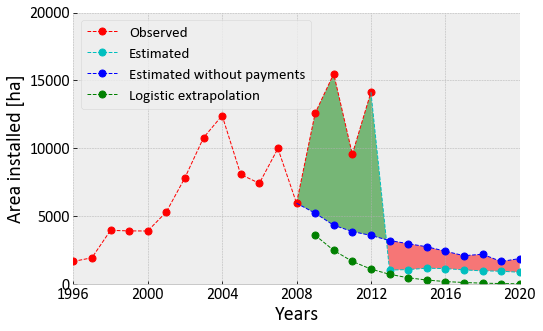

In [98]:
title = "PCF assessment_all"
plot_differential_adoption_all(yearly_adoption_portugal_pred, yearly_adoption_portugal_pred_nop,
                                yearly_adoption_portugal_real, log_extr_d, 20000, title)